In [1]:
import sys,os,mlflow,nltk,re,time,umap
from __future__ import print_function

sys.path.append(os.path.abspath(".."))

from sentence_transformers import SentenceTransformer
import plotly.express as px
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from modules import utils
from hdbscan import HDBSCAN
from sentence_transformers import models
from sklearn.preprocessing import normalize
from transformers import AutoModel, AutoTokenizer
from torch import nn
#tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-german-cased")
%reload_ext utils
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#model = SentenceTransformer('bert-base-wikipedia-sections-mean-tokens')
TOP_N = 1000
TRAIN_N = 10000
# load BERT model from Hugging Face
word_embedding_model = models.Transformer( 
    'T-Systems-onsite/bert-german-dbmdz-uncased-sentence-stsb')

# Apply mean pooling to get one fixed sized sentence vector
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                               pooling_mode_mean_tokens=True,
                               pooling_mode_cls_token=False,
                               pooling_mode_max_tokens=True)

# join BERT model and pooling to get the sentence transformer
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

In [4]:
df=utils.load_text_data().head(TOP_N)
df.head()

,kicker,headline,text,seo_title,created_at,updated_at,site,entities_analyzed
article_uid,,,,,,,,
8c7b60bbbbab27058f93ba3114462b0b9b82f79c3cf3e95e52cf8013742b1f89,Tor nach 3 Sekunden!,Blitz-Comeback von Reus,Wenn du bei deinem Comeback nach 223 Tagen nur...,DFB-Pokal: Duisburg - BVB 0:5! 3 Sekunden nach...,2020-09-14 22:39:16,2020-09-14 22:39:16,www.bild.de,0
66ef992ac10f512ce621314bcffcbc542549ba1f52c8b11696e33d8730998aba,Sie stoppten das Schalke-Spiel,Türkgücü-Bosse erklärenihre Pokal-Klage,Es war DER Aufreger der 1. DFB-Pokal-Runde. T...,DFB-Pokal: Sie stoppten das Schalke-Spiel – Tü...,2020-09-14 22:34:15,2020-09-14 22:35:05,www.bild.de,1
bafa8f876a14f50c6010a8ea2ff4de2265e508af13c5007ddb363a4c4b155f4e,Messer-Angriff von Stolberg,Islamist stachschon einmal zu!,Stolberg/Aachen – Der Messerangriff von Stolbe...,Messer-Angriff von Stolberg - Islamist stach...,2020-09-14 22:34:15,2020-09-14 22:35:05,www.bild.de,1
e353f0b8121a6f0addf3ea3ca5eead419c904d283284fcffcf913ff6f2f39b1c,Hertha verschenkt Machtzentrale,Die neuen Hierarchien der 18 Klubs,Die neue Serie „Die neuen Hierarchien der 18 K...,1. Bundesliga: Die neuen Hierarchien der 18 Kl...,2020-09-14 22:34:15,2020-09-14 22:35:05,www.bild.de,1
f168dc072b52b38187937175639830ef066209100ffaeea780cb03cd943706d3,Verletzte und neue Offensive,Gisdol schon vorm Start unter Druck!,Das hatte sich Markus Gisdol (50) bei seiner V...,1. FC Köln: Markus Gisdol schon vor Liga-Start...,2020-09-14 22:33:16,2020-09-14 22:34:07,www.bild.de,1


## TEXT PREPROCESSING 
Cleaning all the unwanted characters

In [8]:
pdf = utils.preprocess_articles_for_bert(df,lower=True)
df['mix'] = df['kicker'] + " " + df['headline'] +" "+ df["seo_title"].apply(utils.remove_seo_title_marker) + df["text"].apply(lambda x: " ".join(x.split(" ")[:150]))
pdf_mix = utils.preprocess_text(df,col="mix")
pdf[0][:250]

'wenn du bei deinem comeback nach 223 tagen nur drei ! sekunden und genau einen ! ballkontakt für dein erstes pflichtspieltor brauchst. wahnsinns-rückkehr für marco reus bei borussia dortmund mehr als ein halbes jahr nach seinem sehnenriss im februar!'

In [9]:

start_time = time.time()

embeddings = model.encode(pdf,show_progress_bar=True)
print("--- Embeddings shape ",embeddings.shape)
print("--- Documnets encoded %s seconds ---" % (time.time() - start_time))



--- Embeddings shape  (1000, 1536)
--- Documnets encoded 133.10192894935608 seconds ---


In [10]:

umap_data = umap.UMAP(n_neighbors=50, n_components=3, min_dist=0.0, metric='cosine').fit_transform(embeddings)


In [34]:
umap_embeddings = umap.UMAP(n_neighbors=8, 
                            n_components=384, 
                            metric='cosine').fit_transform(embeddings)


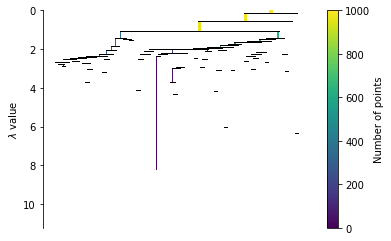

In [35]:
cluster = HDBSCAN(min_cluster_size=6,alpha=0.88,cluster_selection_epsilon=0.11,
                          prediction_data=True
                          ,metric='euclidean',                     min_samples=3,
                          cluster_selection_method='eom',approx_min_span_tree=True).fit(umap_embeddings)
cluster.condensed_tree_.plot(select_clusters=False,max_rectangles_per_icicle=1,label_clusters=True)


In [28]:
def cluster_and_reduce(embeddings,one_day=False,n_components_clustering=384,**kwargs):
    st = time.time()
    umap_data = umap.UMAP(n_neighbors=52, n_components=2, metric='cosine', min_dist=0.70).fit_transform(embeddings)
    print(">> Reducing dimensionality from {} to {} ...".format(embeddings.shape[1],str(n_components_clustering)))
    if len(embeddings) > n_components_clustering:
        umap_embeddings = umap.UMAP(n_neighbors=15, 
                                    n_components=n_components_clustering, 
                                    metric='cosine').fit_transform(embeddings)
    else:
        umap_embeddings = umap.UMAP(n_neighbors=15, 
                                    n_components=n_components_clustering, 
                                    metric='cosine',init="random").fit_transform(embeddings)
    
    params = {"min_cluster_size":4,"alpha":0.85,"cluster_selection_epsilon":0.11
                          ,"metric":'euclidean',"min_samples":5,
                          "cluster_selection_method":'eom',"approx_min_span_tree":True}
        
    if one_day:
        params["min_cluster_size"] = 3
        
    for (k,v) in kwargs.items():
        params[k]=v
        
    print(">> Clustering...")
    clusters = HDBSCAN(**params).fit_predict(umap_embeddings)
    print(">> --- Done in {:.1f} seconds ---".format(time.time() - st))

    return umap_data,clusters


#cluster_and_reduce(embeddings)

In [29]:
# Prepare data
result = pd.DataFrame(umap_data, columns=['x', 'y','z'])
result['labels'] = cluster.labels_
result['headline'] = df.head(TOP_N)["seo_title"].values
result['seo_title'] = df.head(TOP_N)["headline"].values
result['text'] = df.head(TOP_N)["text"].values
result['id'] = df.head(TOP_N).index.values

result['created_at'] = df.head(TOP_N)["created_at"].dt.date.values
result.sort_values(by="created_at")
result['created_at'] = result.created_at.apply(str)
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
print("Outliers: {} | Clustered: {} | {} \n Cluster count: {} ".format(len(outliers),len(clustered),
                                                                 (len(clustered)/(len(outliers)+len(clustered)))
                                                                 ,len(clustered.labels.unique())))

result

Outliers: 185 | Clustered: 815 | 0.815 
 Cluster count: 63 


,x,y,z,labels,headline,seo_title,text,id,created_at
0,3.871603,11.717065,5.111769,27,DFB-Pokal: Duisburg - BVB 0:5! 3 Sekunden nach...,Blitz-Comeback von Reus,Wenn du bei deinem Comeback nach 223 Tagen nur...,8c7b60bbbbab27058f93ba3114462b0b9b82f79c3cf3e9...,2020-09-14
1,3.033881,11.063309,4.840636,45,DFB-Pokal: Sie stoppten das Schalke-Spiel – Tü...,Türkgücü-Bosse erklärenihre Pokal-Klage,Es war DER Aufreger der 1. DFB-Pokal-Runde. T...,66ef992ac10f512ce621314bcffcbc542549ba1f52c8b1...,2020-09-14
2,5.376394,8.602823,2.983510,34,Messer-Angriff von Stolberg - Islamist stach...,Islamist stachschon einmal zu!,Stolberg/Aachen – Der Messerangriff von Stolbe...,bafa8f876a14f50c6010a8ea2ff4de2265e508af13c500...,2020-09-14
3,2.829374,11.546536,5.830324,53,1. Bundesliga: Die neuen Hierarchien der 18 Kl...,Die neuen Hierarchien der 18 Klubs,Die neue Serie „Die neuen Hierarchien der 18 K...,e353f0b8121a6f0addf3ea3ca5eead419c904d283284fc...,2020-09-14
4,3.144677,11.523552,5.859311,22,1. FC Köln: Markus Gisdol schon vor Liga-Start...,Gisdol schon vorm Start unter Druck!,Das hatte sich Markus Gisdol (50) bei seiner V...,f168dc072b52b38187937175639830ef066209100ffaee...,2020-09-14
...,...,...,...,...,...,...,...,...,...
995,4.521420,8.896667,4.373353,18,Weil Verdi nicht mitspielt - VerkaufsZOFFene S...,VerkaufsZOFFene Sonntage,Hannover – Erst im Juli hatte das Wirtschaftsm...,44085af4cdc4946218ad71e91ccd52de07ce67432ab345...,2020-09-09
996,5.190209,8.901073,4.973651,25,Erfindung aus Nürnberg - Frischer Salat aus de...,Frischer Salat aus dem Automaten,Nürnberg – Wer kennt das nicht: Beim Wochenei...,ac99c98bf79b0535351de210d36ce132dc82d99462ff0e...,2020-09-09
997,4.447726,9.452416,4.857747,23,OB Henriette Reker: „Klimaneutrales Köln will ...,Reker: „Klimaneutrales Köln will ich noch erle...,Köln – Klimaschutz und Verkehrswende sind die ...,06af749227495b2143364ab4efd35895d560b31d4d6137...,2020-09-09
998,4.603261,10.661929,5.172396,7,NFL: „Vollmer und Kuhn“-Show ist der Football-...,Buccaneers lösen Versprechenvon Bradys Ex-Klub...,Endlich fliegt das Ei wieder! Die „Vollmer un...,080f9e0033f23540881fd07ecbf503e9066c5151ddb822...,2020-09-09


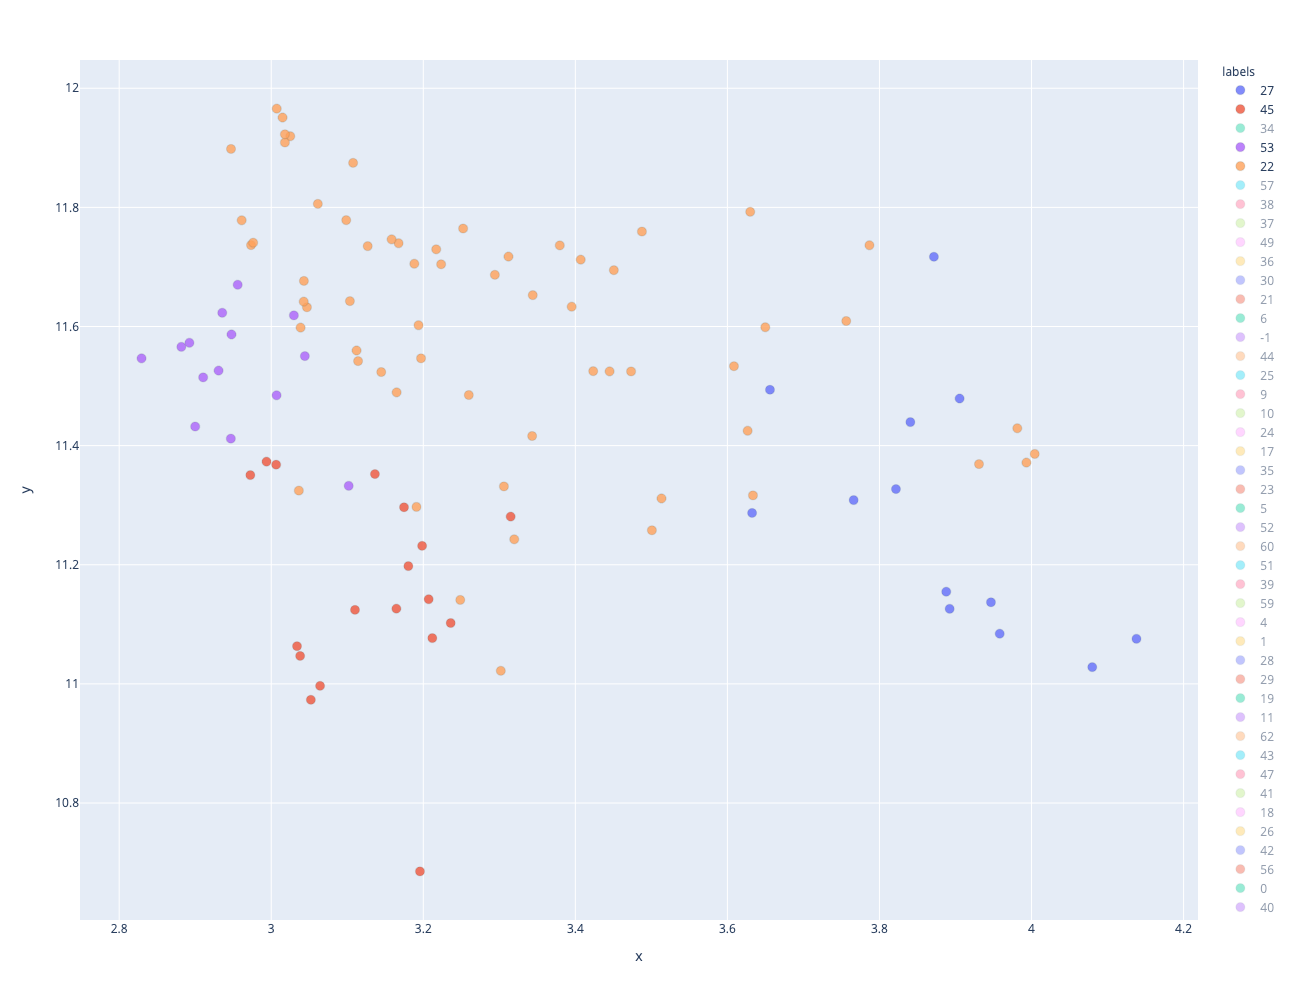

In [30]:
def scatter_plot(result):
    result["labels"] = result.labels.apply(str)
    fig = px.scatter(result, x="x", y="y",hover_name="headline",hover_data=["created_at"], color = "labels",opacity=0.8)
    fig.update_traces(marker=dict(size=9,
                              line=dict(width=0.15,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
    fig["layout"].pop("updatemenus")
    fig.update_layout(
         height=1000)
    fig.show()
    
result["labels"] = result.labels.apply(str)
fig = px.scatter(result, x="x", y="y",hover_name="headline",hover_data=["created_at"], color = "labels",opacity=0.8)
fig["layout"].pop("updatemenus")
fig.update_traces(marker=dict(size=9,
                              line=dict(width=.15,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.update_layout(
     height=1000)
fig.show()

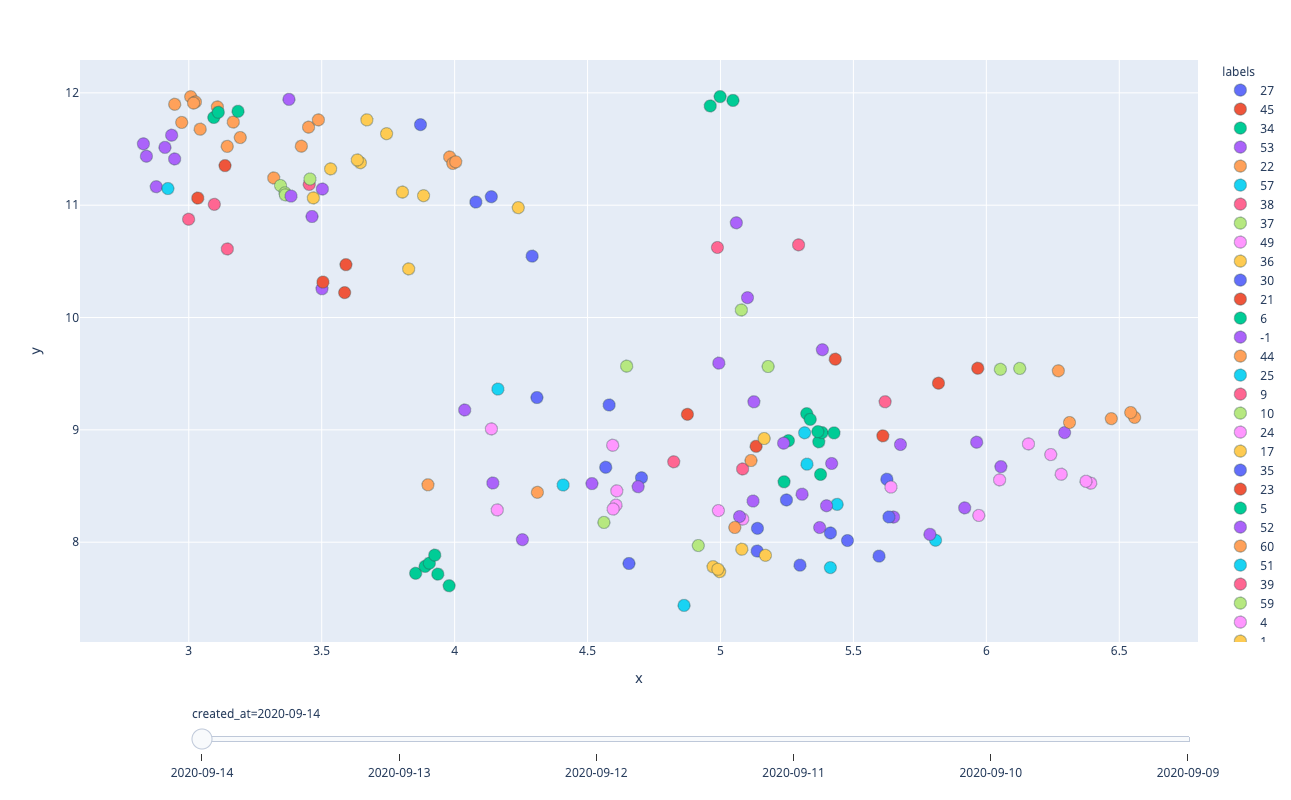

In [40]:

fig = px.scatter(result, x="x", y="y",hover_name="headline", color = "labels", animation_frame="created_at")
fig["layout"].pop("updatemenus")
fig.update_traces(marker=dict(size=12,
                              line=dict(width=.35,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.update_layout(
     height=800)
fig.show()

#### Summarizing cluster descriptions

In [23]:
###

docs_df = pd.DataFrame(pdf_mix, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] =df.index.values#df["article_uid"]#range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})


tf_idf, count = utils.c_tf_idf(docs_per_topic.Doc.values, m=len(pdf))
top_n_words = utils.extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
top_3_words_per_topic = pd.DataFrame([(k," | ".join([e[0] for e in v][:5]))  for (k,v) in top_n_words.items()],columns=["Topic","top_n_words"])

top_3_words_per_topic["Topic"]=top_3_words_per_topic["Topic"].apply(int)
topic_sizes = extract_topic_sizes(docs_df)
topic_sizes.head(10)


Number of stopwords 607


,Topic,Size
0,-1,185
23,22,62
5,4,46
37,36,32
31,30,28
35,34,28
45,44,25
2,1,23
1,0,19
57,56,18


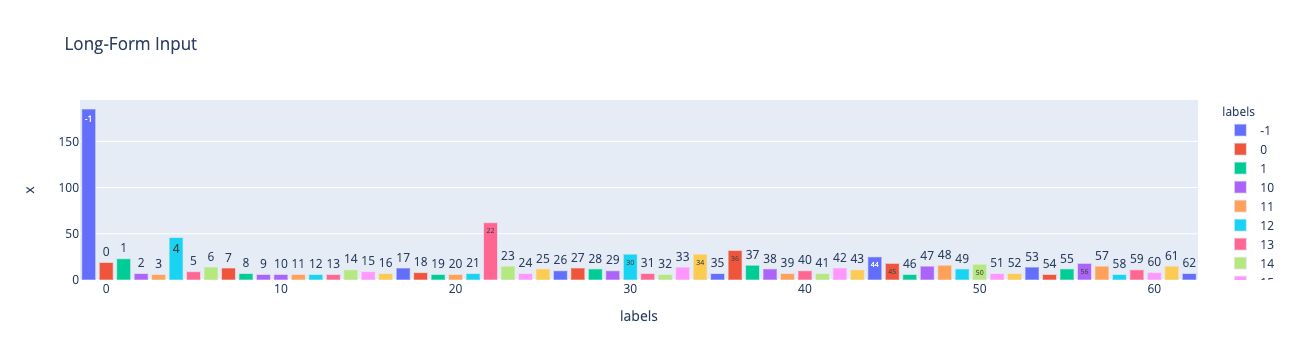

In [27]:
result.labels = result.labels.astype(str)
top_3_words_per_topic.Topic = top_3_words_per_topic.Topic.astype(str)
results = pd.merge(result, top_3_words_per_topic, how='left', left_on="labels",right_on="Topic")
results.groupby(['labels',"top_n_words"]).count()

fig = px.bar(results.groupby(['labels',"top_n_words"]).count().reset_index(), x="labels", y="x",text="labels", color="labels",hover_name="top_n_words",title="Long-Form Input")
fig.update_layout(
     height=250)

fig.show()

In [39]:
results = pd.merge(result, top_3_words_per_topic, how='left', left_on="labels",right_on="Topic")
results.groupby(["created_at",'labels',"top_n_words"]).count()

fig = px.bar(results.groupby(["created_at",'labels',"top_n_words"]).count().reset_index(), x="labels", y="x",text="labels", color="labels",hover_name="top_n_words",title="Long-Form Input",facet_row="created_at")
fig.update_layout(
     height=1000)

fig.show()

NameError: name 'top_3_words_per_topic' is not defined

# Bar chart

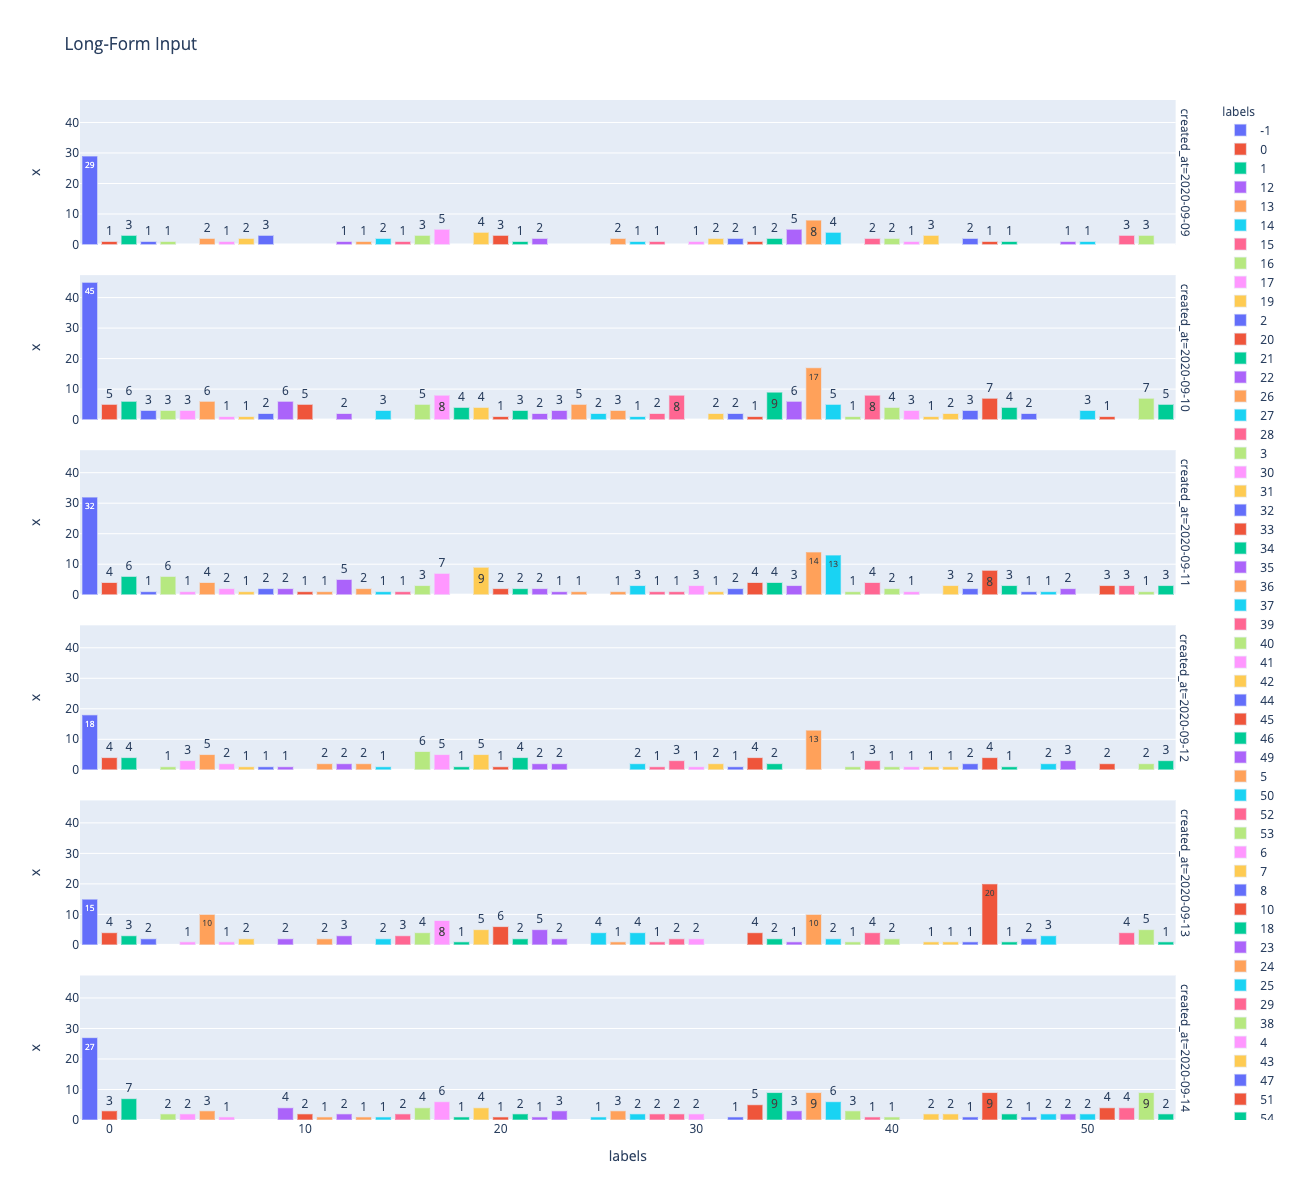

In [556]:
fig = px.bar(results.groupby(["created_at",'labels',"top_n_words"]).count().reset_index(), x="labels", y="x", color="labels",hover_name="top_n_words",
         title="Long-Form Input",facet_row="created_at",text="x")
fig.update_layout(
     height=1200)

fig.show()

In [32]:
df=utils.load_text_data().head(10000)
pdf=utils.preprocess_text(df)
two_weeks_arr = [df[df.created_at.dt.date == pd.to_datetime("{}/09/2020".format(day),dayfirst=True)] for day in range(2,15)]

In [33]:
def bert_topic_model(df,model):
    start_time=time.time()
    pdf=utils.pre(df)
    emb= model.encode(pdf,show_progress_bar=True)
    umap_data, cluster_labels =cluster_and_reduce(emb)
    result = pd.DataFrame(umap_data, columns=['x', 'y','z'])
    result['labels'] = cluster_labels
    result['headline'] = df["seo_title"].values
    result['seo_title'] = df["headline"].values
    result['created_at'] = df["created_at"].dt.date.values
    outliers = result.loc[result.labels == -1, :]
    clustered = result.loc[result.labels != -1, :]
    print("--- %s seconds ---" % (time.time() - start_time))

    print("Outliers: {} | Clustered: {} | {} \n Cluster count: {} ".format(len(outliers),len(clustered),
                                                                 (len(clustered)/(len(outliers)+len(clustered)))
                                                                 ,len(clustered.labels.unique())))
    
    docs_df = pd.DataFrame(pdf, columns=["Doc"])
    docs_df['Topic'] = cluster_labels
    docs_df['Doc_ID'] =df.index.values#df["article_uid"]#range(len(docs_df))
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    return result,docs_per_topic

res,docs_per_topic =bert_topic_model(two_weeks_arr[1],model)

scatter_plot(res)



>> Reducing dimensionality from 1536 to 384 ...
>> Clustering...
>> --- Done in 4.3 seconds ---


ValueError: Shape of passed values is (245, 2), indices imply (245, 3)

In [420]:
two_weeks_res = [bert_topic_model(day)[0] for day in two_weeks_arr]


--- 35.987898111343384 seconds ---
Outliers: 33 | Clustered: 246 | 0.8817204301075269 
 Cluster count: 12 



--- 38.31494379043579 seconds ---
Outliers: 46 | Clustered: 199 | 0.8122448979591836 
 Cluster count: 13 



--- 34.016526222229004 seconds ---
Outliers: 32 | Clustered: 176 | 0.8461538461538461 
 Cluster count: 11 



--- 25.576088190078735 seconds ---
Outliers: 15 | Clustered: 146 | 0.906832298136646 
 Cluster count: 12 



--- 37.52465105056763 seconds ---
Outliers: 12 | Clustered: 169 | 0.9337016574585635 
 Cluster count: 13 



--- 49.15345883369446 seconds ---
Outliers: 35 | Clustered: 193 | 0.8464912280701754 
 Cluster count: 9 



--- 45.62162375450134 seconds ---
Outliers: 0 | Clustered: 244 | 1.0 
 Cluster count: 2 



--- 35.64262318611145 seconds ---
Outliers: 25 | Clustered: 212 | 0.8945147679324894 
 Cluster count: 17 



--- 37.757420778274536 seconds ---
Outliers: 29 | Clustered: 206 | 0.8765957446808511 
 Cluster count: 14 



--- 29.424973964691162 seconds ---
Outliers: 34 | Clustered: 153 | 0.8181818181818182 
 Cluster count: 14 



--- 21.722954034805298 seconds ---
Outliers: 4 | Clustered: 125 | 0.9689922480620154 
 Cluster count: 6 



--- 26.20570993423462 seconds ---
Outliers: 27 | Clustered: 135 | 0.8333333333333334 
 Cluster count: 10 



--- 27.014282941818237 seconds ---
Outliers: 13 | Clustered: 159 | 0.9244186046511628 
 Cluster count: 7 


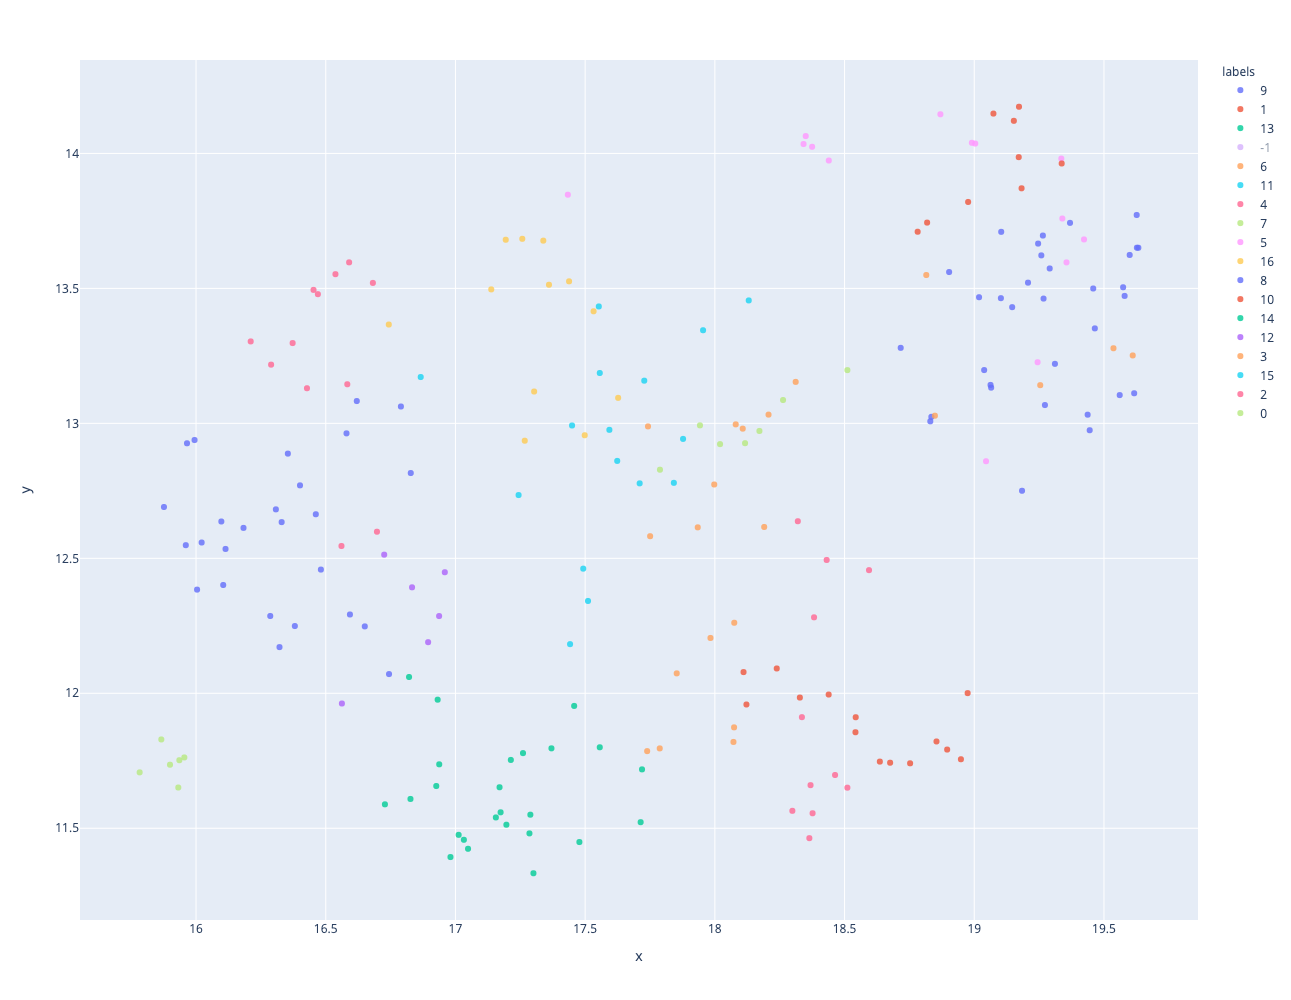

In [532]:
scatter_plot(two_weeks_res[7])

## Expreiment with Paraphrase mininng 

In [117]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

# Single list of sentences - Possible tens of thousands of sentences

sentences = pdf

#paraphrases = util.paraphrase_mining(model, sentences)
paraphrases_df = pd.DataFrame(paraphrases,columns=["score","a","b"])
paraphrases_df[["a","b"]]=paraphrases_df[["a","b"]].applymap(lambda x: df.seo_title.values[x])
paraphrases_df

,score,a,b
0,1.000000,Nawalny wird nicht mehr künstlich beatmet – Ch...,Nawalny wird nicht mehr künstlich beatmet – Ch...
1,1.000000,Zum Tag des Handwerks - Wir haben's in der Han...,Zum Tag des Handwerks - Wir haben's in der Han...
2,0.955451,Blutige Attacke: Teenager geraten wegen Frauen...,Niedersachsen: Corona-Tests für Lehrer -Hanno...
3,0.954539,Leipzig: Hündin vor Supermarkt geklaut: Lotta ...,Leipzig: Hund Lotta beim Einkaufen entführt! ...
4,0.949102,Düsseldorf: 1.Hochschul-Studie zeigt die Wahrh...,Düsseldorf: Jecken überlegen Karneval in den F...
...,...,...,...
80515,0.553856,NBA: LeBron James führt Los Angeles Lakers ins...,Beckenbauer über den Tod seines Sohnes: „Der g...
80516,0.553557,NBA: LeBron James führt Los Angeles Lakers ins...,FC St. Pauli: Rodrigo Zalazar macht es beim Fr...
80517,0.553351,NBA: LeBron James führt Los Angeles Lakers ins...,USA: Präsident Donald Trump redet sich nach Co...
80518,0.553091,NBA: LeBron James führt Los Angeles Lakers ins...,Conor McGregor zeigte einer Frau seinen Penis:...


In [ ]:
paraphrases_df.query("Nawalny ")

In [42]:
os.path.dirname("./ads/samples/xsd.xs")

'./ads/samples'